In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
%matplotlib inline

In [2]:
# Read in data
bsu=pd.read_excel(r"N:\Planning - New File Structure\Performance\Annual Report\Arrival Report Boise State Downtown Main Street Stop NOV2017toNOV18.xlsx")
bsu=pd.DataFrame(bsu)

In [3]:
# Clean up data by dropping any blank info (we have plenty of good stuff to work with)
bsu=bsu.dropna(axis=0,how='any')

In [4]:
# We'll use this later
cols=['Early','OnTime','Late']

In [5]:
# Sort rows so that they're sequential
bsu.sort_values('Arrival Date',inplace=True)

In [6]:
# Calculate Headway by subtracting arrival time from previous arrival time, clean up any wonkiness
bsu['Headway']=bsu['Arrival Date'].diff()
bsu['Invalid']=np.logical_or(np.logical_or(bsu['Headway']>"02:00:00",bsu['Headway']<"-01:00:00"),(bsu['Headway']<=datetime.timedelta(seconds=0)))
bsu=bsu[bsu.Invalid==False]
# Get date of trip
bsu['date']=bsu['Arrival Date'].dt.date
# Get time of trip
bsu['time']=bsu['Arrival Date'].dt.time
# pull off hour and month for aggregatting purposes
bsu['hour']=[r.hour for r in bsu.time]
bsu['month']=[r.month for r in bsu.date]
# Calculate the % difference between each row and previous 5 timepoints. This should allow for more fluctuation  This will be how we calculate headway adherence 
bsu['pct_headway']=bsu.Headway.pct_change(periods=5)

In [7]:
# All trips less than 50% of the rolling average will be counted as early
bsu['Early']=np.where(bsu['pct_headway']<-.5,True,False)

In [8]:
# All trips more than 50% of rolling average will be counted as late
bsu['Late']=np.where(bsu['pct_headway']>1.5,True,False)

In [9]:
# Drop the first 6 columns that were used to establish the headway & rolling average
bsu=bsu.dropna(axis=0,how='any')

In [10]:
# Count as on-time if between -50% and 50%
bsu['OnTime']=np.logical_and(bsu['Early']==False,bsu['Late']==False)

In [11]:
# Get OTP by hour of day and month of year
bsu_hour_month=bsu.groupby(['hour','month'])[cols].sum()

In [12]:
# Convert to percent
bsu_hour_month['Early_pct']=(bsu_hour_month['Early']/bsu_hour_month[cols].sum(axis=1))*100
bsu_hour_month['OnTime_pct']=(bsu_hour_month['OnTime']/bsu_hour_month[cols].sum(axis=1))*100
bsu_hour_month['Late_pct']=(bsu_hour_month['Late']/bsu_hour_month[cols].sum(axis=1))*100

In [13]:
# The plotting function doesn't like using the DataFrame index as an axis.
bsu_hour_month.reset_index(inplace=True)

In [14]:
# Set up the data for heatmapping
heat=bsu_hour_month.pivot("hour","month","OnTime_pct")

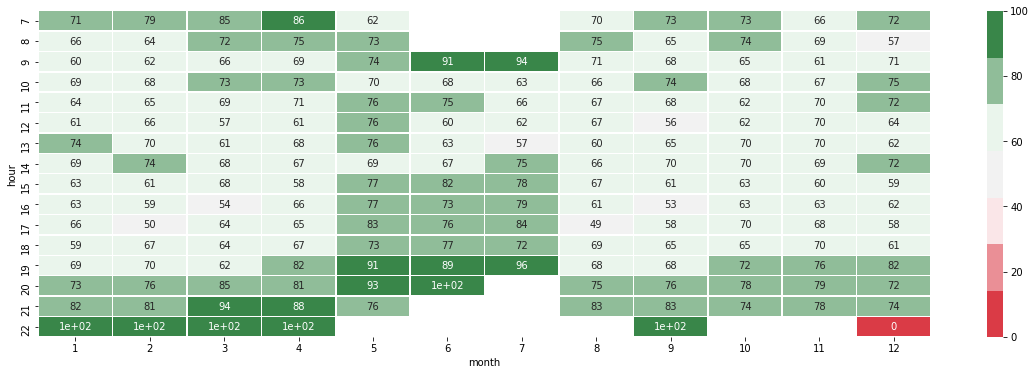

In [15]:
# Make a heatmap!
f, ax=plt.subplots(figsize=(20,6))
heatmap=sns.heatmap(heat,annot=True,linewidths=.5,ax=ax,cmap=sns.diverging_palette(10,133,sep=80,n=7))

In [16]:
# Looking at the heatmap, it looks like the route is timed well for high traffic, low-ridership times.
# The on-time performance is best in the PM peak, off-school year.

In [17]:
# Basic statistical summary of the headway information
bsu.Headway.describe()

count                     20395
mean     0 days 00:09:41.384113
std      0 days 00:05:25.651236
min             0 days 00:00:01
25%             0 days 00:05:38
50%             0 days 00:08:41
75%             0 days 00:12:44
max             0 days 00:36:22
Name: Headway, dtype: object

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


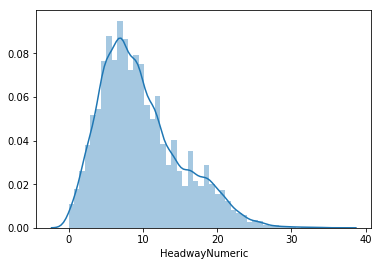

In [18]:
bsu['HeadwayNumeric']=(pd.to_numeric(bsu['Headway'],downcast='integer'))/60000000000
sns.distplot(bsu['HeadwayNumeric'])

In [22]:
heatmap.figure.savefig(r"N:\Planning - New File Structure\Performance\Annual Report\bsu_heatmap.png")